In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [1]:
import numpy as np

import cv2

import skimage
from skimage import io, transform, feature, color, exposure, draw

from sklearn import svm, model_selection, metrics

from pasuryan.datasets import colorferet
from pasuryan.improc import filters
from pasuryan.powerup import indextra
from pasuryan.feature import hog

from matplotlib import pyplot as plt



In [2]:
print("Loading colorferet data...")
clf_images = None
clf_targets = None

try:
    clf_images = np.load('.temp/clf_images.npy')
    clf_targets = np.load('.temp/clf_targets.npy')
    print("--loaded temp dataset--")
except:
    print("--build and save dataset--")
    clf_images, clf_targets = colorferet.load_data(label='gender', subset='smaller') # TODO add gender keyword, use images subset
    np.save('.temp/clf_images.npy', clf_images)
    np.save('.temp/clf_targets.npy', clf_targets)
# except:
    # pass

print(clf_images.shape, clf_targets.shape)
print("M:{}".format(np.sum(clf_targets)))
print("F:{}".format((clf_targets.size - np.sum(clf_targets))))
# print(clf_images.size, clf_targets.size)
# print(clf_images.dtype, clf_targets.dtype)
# print(clf_images.nbytes, clf_targets.nbytes)
print("... finish!! \^^/")


Loading colorferet data...
--loaded temp dataset--
(2722, 384, 256, 3) (2722,)
M:1715
F:1007
... finish!! \^^/


In [3]:
# WARNING large memory problem, use for loop.

# gamma correction
# clf_images = [exposure.adjust_gamma(x, gamma=10/22) for x in clf_images]

# convert to gray 
print("Converting to gray...")
clf_images_bw = None

try:
    clf_images_bw = np.load('.temp/clf_images_bw.npy')
    print("--loaded temp bw images--")
except:
    print("--build and save bw images--")
    ## ITU-R 601-2 luma transform (PIL.Image.convert('L'))
    ## L = R * 0.299  + G * 0.587   + B * 0.114
    _Lcoef = np.array([0.299,0.587,0.114])
    ## CRT transform (skimage.color.rgb2gray())
    ## L = R * 0.2125 + G * 0.7154  + B * 0.0721 
    # _Lcoef = np.array([0.2125,0.7154,0.0721])
    ## equal value
    ## L = ( R + G + B ) / 3
    # _Lcoef = np.array([1/3]*3)
    clf_images_bw = [ np.sum(_Lcoef[None,None,:]*img, axis=-1).astype('uint8') for img in clf_images ]
    np.save('.temp/clf_images_bw.npy', clf_images_bw)
    
print("... done! XD")


Converting to gray...
--loaded temp bw images--
... done! XD


In [5]:

face_imgs, face_targets, noface_imgs, noface_targets = [],[],[],[]
# rzd_face_imgs, rzd_noface_imgs = [],[]

try:
    face_imgs, face_targets, noface_imgs, noface_targets = np.load('.temp/face_noface_imgs.npy')
    print("--loaded temp bw face images--")
except:
    print("--build and save bw face images--")
            
    #Windows
    # faceCascade = cv2.CascadeClassifier(cv2.haarcascades+'haarcascade_frontalface_default.xml')
    # faceCascade = cv2.CascadeClassifier('../Library/etc/haarcascades/haarcascade_frontalface_default.xml')
    faceCascade = cv2.CascadeClassifier("A:\ProgramData\Anaconda3\envs\pencit\Library\etc\haarcascades\haarcascade_frontalface_default.xml")
    #Linux
    # faceCascade = cv2.CascadeClassifier("/media/otivedani/Alpha/~linux/anaconda3/envs/pencit/share/OpenCV/haarcascades/haarcascade_frontalface_default.xml")

    # maxh, maxw for resizing later
    max_h, max_w = (0, 0)
    _rz_factor = 1

    tmp_face_imgs, tmp_noface_imgs = [],[]
    face_rects = []

    print("Detect face with opencv haarcascade...")
    # iterate over array
    for i, img_bw in enumerate(clf_images_bw):
        try:
            facepos = faceCascade.detectMultiScale(img_bw,1.2,5)
            x,y,w,h = facepos[0]
            w = int(w*_rz_factor)
            h = int(h*_rz_factor)
            max_h = h if (max_h < h) else max_h
            max_w = w if (max_w < w) else max_w
            #found face!
            roi_face = img_bw[y:y+h, x:x+w]
            tmp_face_imgs.append(roi_face)
            face_targets.append(clf_targets[i])

            #save rectangles
            face_rects.append((x,y,x+w,y+h))
        except:
            #no face?
            tmp_noface_imgs.append(img_bw)
            noface_targets.append(clf_targets[i])

    #make all face same size
    #use CV
    face_imgs   = [ cv2.resize(fimg,(max_w,max_h)) for fimg in tmp_face_imgs ]
    noface_imgs = [ cv2.resize(fimg,(max_w,max_h)) for fimg in tmp_noface_imgs ]
    # #use skimage
    # rzd_face_imgs   = [ transform.resize(fimg,(max_h,max_w)) for fimg in face_imgs ]
    # rzd_noface_imgs = [ transform.resize(fimg,(max_h,max_w)) for fimg in noface_imgs ]
    np.save('.temp/face_noface_imgs.npy', (face_imgs, face_targets, noface_imgs, noface_targets))

print("faces : ",len(face_imgs), len(face_targets) )
print("no face : ",len(noface_imgs), len(noface_targets) )
print("...done resizing too!")


--build and save bw face images--
Detect face with opencv haarcascade...
faces :  2657 2657
no face :  65 65
...done resizing too!


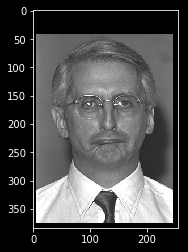

In [6]:
sample_idx = 0

_ptmax, _ptmin = np.amax(np.array(face_rects), axis=0), np.amin(np.array(face_rects), axis=0)

_pts = np.array([_ptmin[0], _ptmin[1], _ptmax[2], _ptmax[3]])
_ixr = np.array([[0,2,2,0,0], [3,3,1,1,3]])
face_sample_img = clf_images_bw[sample_idx].copy()

_rr, _cc = draw.polygon(_pts[_ixr][1], _pts[_ixr][0], face_sample_img.shape)

# f, axs = plt.subplots(1,3)
# axs[0].imshow(clf_images_bw[sample_idx])
# axs[1].imshow()
# axs[2].imshow()

_face_mask = np.zeros(face_sample_img.shape)
_face_mask[_rr,_cc] = 1.
face_sample_img = np.multiply(face_sample_img,_face_mask)
plt.imshow(face_sample_img, cmap='gray')
plt.show()


In [8]:
from pasuryan.misc import HOGparamSync
# numpy rodering nr,nc
HOGparamdict = {
    'wsz': (int(8*(max_h//8)), int(8*(max_w//8))),
    'ppc': (8, 8),
    'cpb': (1, 1),
    'bstride': (1, 1),
    'nbins': 9,
    'norm': 'L2',
    'vis': True
}

HOGparamSync.init_hogparam(HOGparamdict)
HOGparamSync.get_cv_hogparam('.temp/cv2HOGparam_face.yml')
_cv2HOGdesc = cv2.HOGDescriptor('.temp/cv2HOGparam_face.yml')

myHOGparam = HOGparamSync.get_my_hogparam()
skHOGparam = HOGparamSync.get_sk_hogparam()
print("initialized HOG parameter :\n" + str(HOGparamdict))


initialized HOG parameter :
{'wsz': (208, 208), 'ppc': (8, 8), 'cpb': (1, 1), 'bstride': (1, 1), 'nbins': 9, 'norm': 'L2', 'vis': True}


In [9]:
cv2hogs = []
skhogs = []
myhogs = []
myhogs_alt = []

myHOGparam_alt = myHOGparam.copy()
myHOGparam_alt['useInterpolation'] = not myHOGparam_alt['useInterpolation']

print("Build HOG features...")
for img in face_imgs:
    #opencv
    cv2hog = np.array(_cv2HOGdesc.compute(img.T)).ravel()
    cv2hogs.append(cv2hog)

# for img in face_imgs: #disable this 'for' loop for building skhog / myhog using resized images
    #skhog
    skhog = skimage.feature.hog(img, **skHOGparam)
    skhogs.append(skhog)

    #myhog
    myhog = hog(img, **myHOGparam)
    myhogs.append(myhog)

    #myhog alt
    myhog_alt = hog(img, **myHOGparam_alt)
    myhogs_alt.append(myhog_alt)

#show few samples

#try using unprocessed image
raw_myhogs = [ hog(img, **myHOGparam) for img in clf_images_bw ]
# raw_img_bw = np.array(clf_images_bw).reshape(len(clf_images_bw),-1).copy()
# realitycheck
print(myHOGparam_alt['useInterpolation'], myHOGparam['useInterpolation'])
print("...build HOGs, done")


Build HOG features...
False True
...build HOGs, done


In [10]:

modelsets = (
    ('cv2 HOG - face', cv2hogs, face_targets),
    ('sklearn HOG - face', skhogs, face_targets),
    ('my HOG - face', myhogs, face_targets),
    ('my HOG - alt form', myhogs_alt, face_targets),
    ('my HOG - no face crop', raw_myhogs, clf_targets)
)

#comparing models
for i, (nama, in_X, in_Y) in enumerate(modelsets):
    print("----------------------------")
    # split train test data
    print("Using Feature : ", nama)

    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
        in_X, in_Y, test_size=0.3, random_state=114
    )

    print("\ntraining data: ")
    print(len(X_train), len(Y_train))
    print("\ntesting data: ")
    print(len(X_test), len(Y_test))
    print("----------------------------")
    
    #model check, overfit or not
    clf = svm.SVC(gamma='scale', decision_function_shape='ovo')
    scores = model_selection.cross_val_score(clf, X_train, Y_train, cv=10, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
    #model training
    print("Training in progress...")
    clf.fit(X_train, Y_train)
    pred_Y_test = clf.predict(X_test)
    
    print("Validation set")
    print('Accuracy Score : ' + str(metrics.accuracy_score(Y_test, pred_Y_test)))
    print('Precision Score : ' + str(metrics.precision_score(Y_test, pred_Y_test, average='weighted')))
    print('Recall Score : ' + str(metrics.recall_score(Y_test, pred_Y_test, average='weighted')))
    print('F1 Score : ' + str(metrics.f1_score(Y_test, pred_Y_test, average='weighted')))
    # print("Report:\n", metrics.classification_report(Y_test, pred_Y_test, target_names=data.keys()))

    print("Finished~ \^^/")
    print("==============================================================","\n")



----------------------------
Using Feature :  cv2 HOG - face

training data: 
1859 1859

testing data: 
798 798
----------------------------
Accuracy: 0.95 (+/- 0.03)
Training in progress...
Validation set
Accuracy Score : 0.9598997493734336
Precision Score : 0.9603703602941843
Recall Score : 0.9598997493734336
F1 Score : 0.9595916327550512
Finished~ \^^/

----------------------------
Using Feature :  sklearn HOG - face

training data: 
1859 1859

testing data: 
798 798
----------------------------
Accuracy: 0.96 (+/- 0.03)
Training in progress...
Validation set
Accuracy Score : 0.9598997493734336
Precision Score : 0.9605548616133062
Recall Score : 0.9598997493734336
F1 Score : 0.9595540215043082
Finished~ \^^/

----------------------------
Using Feature :  my HOG - face

training data: 
1859 1859

testing data: 
798 798
----------------------------
Accuracy: 0.96 (+/- 0.02)
Training in progress...
Validation set
Accuracy Score : 0.9636591478696742
Precision Score : 0.9639550264550264


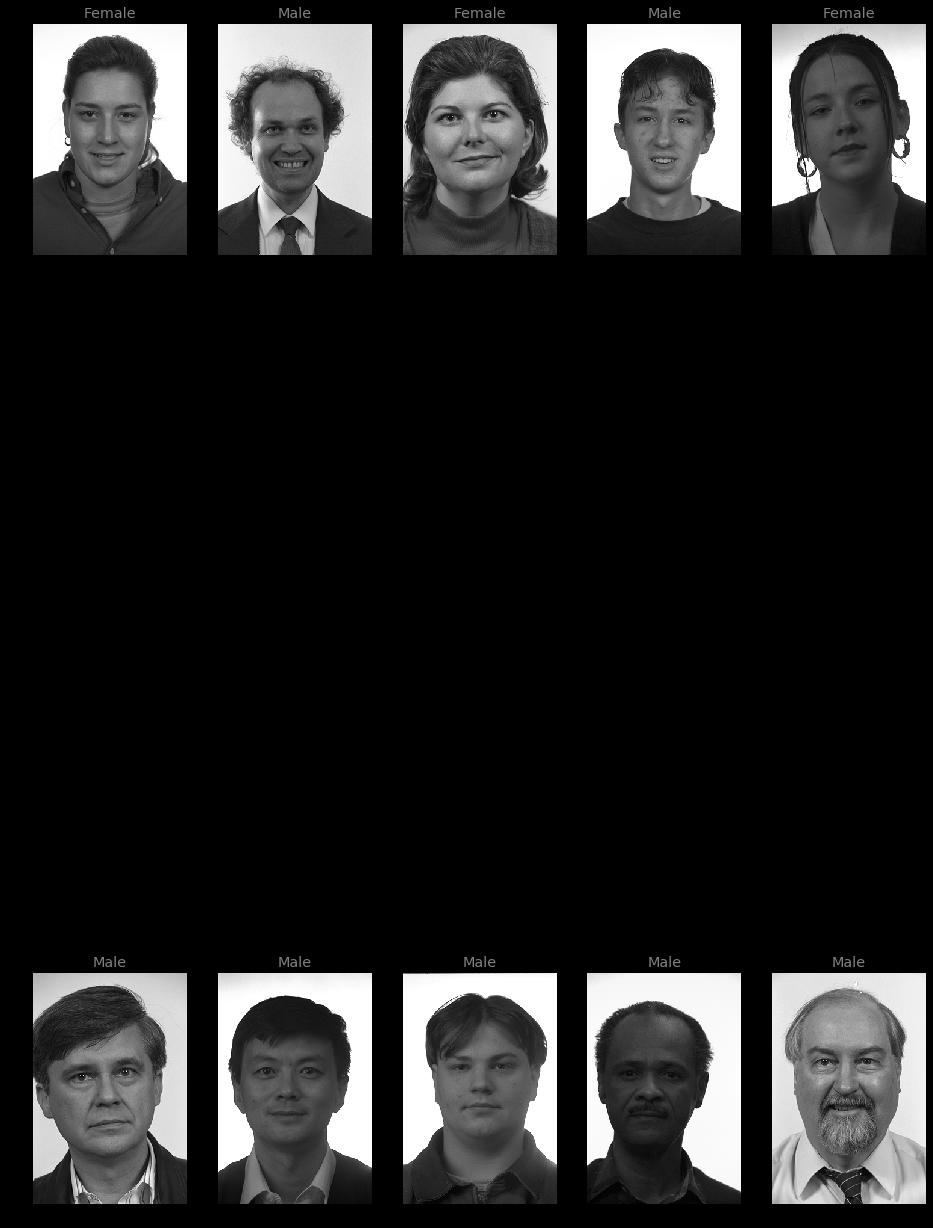

In [11]:
show_size = (2,5)

sample_ix = np.random.choice(len(clf_images_bw),show_size)
f, axs = plt.subplots(*show_size, figsize=(16,32))
# print((len(axs)))
# ax[0].imshow(clf_images_bw[sample_ix[0]])
# ax[1].imshow(clf_images_bw[sample_ix[1]])
for i, ax in np.ndenumerate(axs):
    ax.imshow(clf_images_bw[sample_ix[i]], cmap='gray')
    ax.axis('off')
    ax.set_title('Female' if clf_targets[sample_ix[i]] == 0 else 'Male', color='gray', fontsize='x-large')



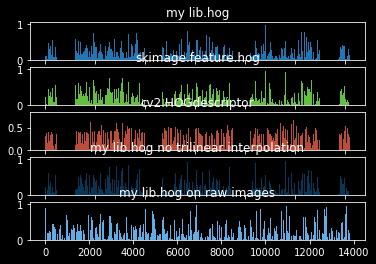

In [12]:
fig, axs = plt.subplots(5,1)
# ,constrained_layout=True
axs[0].bar(np.arange(myhogs[0].size),height=myhogs[0], color=[0.122, 0.467, 0.706, 1.0])
axs[0].set_title('my lib.hog')
axs[1].bar(np.arange(skhogs[0].size),height=skhogs[0], color=[0.388, 0.749, 0.251, 1.0])
axs[1].set_title('skimage.feature.hog')
axs[2].bar(np.arange(cv2hogs[0].size),height=cv2hogs[0], color=[0.737, 0.302, 0.22 , 1.0])
axs[2].set_title('cv2.HOGdescriptor')
axs[3].bar(np.arange(myhogs_alt[0].size),height=myhogs_alt[0], color=[0.03137,  0.21176,  0.33725, 1.0])
axs[3].set_title('my lib.hog no trilinear interpolation')
axs[4].bar(np.arange(raw_myhogs[0].size),height=raw_myhogs[0], color=[0.37647,  0.68235,  0.89804, 1.0])
axs[4].set_title('my lib.hog on raw images')
plt.show()
